# Subgradient Optimization with Python/Gurobi
## [Jon Lee](https://sites.google.com/site/jonleewebpage/home), 11/2/2020

Apply Subgradient Optimization to:

\begin{align*}\tag{Q}
z = \min~& c'x\\
&Ex  \geq h\\
&Ax  = b\\
& x \geq 0,
\end{align*}
relaxing $Ex  \geq h$ in the Lagrangian.

References:
* Jon Lee, "A First Course in Linear Optimization", Fourth Edition (Version 4.0), Reex Press, 2013-20.

MIT License

Copyright (c) 2020 Jon Lee

Permission is hereby granted, free of charge, to any person obtaining a copy 
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
%reset -f
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [2]:
MAXIT = 500
HarmonicStepSize = False       # If you choose False, then you have to guess a 'target value'
GUESS = -5.6                   #   but don't guess a target value higher than z!!!!
SmartInitialization = True     # Set 'False' to initialize with y=0.

# generate a random example
n = 100   # number of variables
m1 = 200  # number of equations to relax
m2 = 50  # number of equations to keep
np.random.seed(25)   # change the seed for a differemt example 
E=0.01*np.random.randint(-5,high=5,size=(m1,n)).astype(float) #np.random.randn(m1,nt)
A=0.01*np.random.randint(-2,high=3,size=(m2,n)).astype(float) #np.random.randn(m2,nt)

# choose the right-hand sides so that Q will be feasible
xfeas=0.1*np.random.randint(0,high=5,size=n).astype(float)
h=E.dot(xfeas) - 0.1*np.random.randint(0,high=10,size=m1).astype(float)      
b=A.dot(xfeas)

# choose the objective function so that the dual of Q will be feasible
yfeas=0.1*np.random.randint(0,high=5,size=m1).astype(float)
pifeas=0.1*np.random.randint(-5,high=5,size=m2).astype(float)
c=np.transpose(E)@yfeas + np.transpose(A)@pifeas +  0.1*np.random.randint(0,high=1,size=n).astype(float)   

In [3]:
# solve the problem as one big LP --- for comparison purposes
modelQ = gp.Model()
modelQ.reset()
x = modelQ.addMVar(n)  
objective = modelQ.setObjective(c@x, GRB.MINIMIZE)
constraintsQ1 = modelQ.addConstr(E@x >= h)
constraintsQ2 = modelQ.addConstr(A@x == b)
modelQ.optimize()
if modelQ.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", modelQ.status)
    print("***** This is a problem. Model Q does not have an optimal solution")
    raise StopExecution

Academic license - for non-commercial use only - expires 2021-08-26
Using license file C:\Users\jonxlee\gurobi.lic
Discarded solution information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 250 rows, 100 columns and 21957 nonzeros
Model fingerprint: 0xd5eae979
Coefficient statistics:
  Matrix range     [1e-02, 5e-02]
  Objective range  [2e-02, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-18, 1e+00]
Presolve time: 0.01s
Presolved: 250 rows, 100 columns, 21957 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.2122000e+31   1.799360e+33   4.212200e+01      0s
     211   -5.6119344e+00   0.000000e+00   0.000000e+00      0s

Solved in 211 iterations and 0.04 seconds
Optimal objective -5.611934358e+00


In [4]:
# 'SmartInitialization' chooses the initial y so that the dual of the Lagrangian Subproblem has (pi=0 as) 
# a feasible solution, thus making sure that the initial Lagrangian Subproblem is not unbounded.
if SmartInitialization:
    modelY = gp.Model()
    modelY.reset()
    yvar = modelY.addMVar(m1)  
    constraintsY = modelY.addConstr(np.transpose(E)@yvar <= c)
    modelY.optimize()
    y=yvar.X
else: y=np.zeros(m1)

# initialization 
k=1
bestlb = -np.Inf

# set up the Lagrangian relaxation
modelL = gp.Model()
modelL.reset()
modelL.setParam('OutputFlag', 0)   # quiet the Gurobi output 
x = modelL.addMVar(n)  
constraintsL = modelL.addConstr(A@x == b)
objective = modelL.setObjective((c-y.dot(E))@x, GRB.MINIMIZE)

modelL.optimize()
if modelL.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", modelL.status)
    print("***** This is a problem. Lagrangian Subproblem is unbounded.")
    print("***** The algorithm cannot work with this starting y.")
    raise StopExecution
v = y.dot(h) + modelL.Objval
results1=[0]
results2=[v]
bestlb = v

Discarded solution information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 100 rows, 200 columns and 17965 nonzeros
Model fingerprint: 0x64395335
Coefficient statistics:
  Matrix range     [1e-02, 5e-02]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 5e-01]
Presolve time: 0.01s
Presolved: 100 rows, 200 columns, 17965 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.684880e+02   0.000000e+00      0s
      79    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 79 iterations and 0.03 seconds
Optimal objective  0.000000000e+00
Discarded solution information


In [5]:
while k < MAXIT:
    k += 1
    g = h - E.dot(x.X)
    if HarmonicStepSize:
        stepsize = 1/k             # This one converges in theory, but it is slow.
    else:                          # Instead, you can make a GUESS at the max
        stepsize = (GUESS - v)/(g@g)   # and then use this 'Polyak' stepsize
    y = np.maximum(y + stepsize*g, np.zeros(m1))   # The projection keeps y>=0. 
    objective = modelL.setObjective((c-y.dot(E))@x, GRB.MINIMIZE)
    modelL.optimize()
    if modelL.status != GRB.Status.OPTIMAL:
        k -= 1
        print("***** Gurobi solve status:", GRB.OPTIMAL)
        print("***** This is a problem. Lagrangian Subproblem is unbounded.")
        print("***** The algorithm cannot continue after k =",k)
        break
    v = y.dot(h) + modelL.Objval
    bestlb = np.max((bestlb,v))
    results1=np.append(results1,k-1)
    results2=np.append(results2,v)
 
print("***** z:", modelQ.Objval)
print("***** first lower bound:", results2[0])
print("***** best lower bound:", bestlb)

***** z: -5.611934358015312
***** first lower bound: -35.97487470911054
***** best lower bound: -6.309166317427381


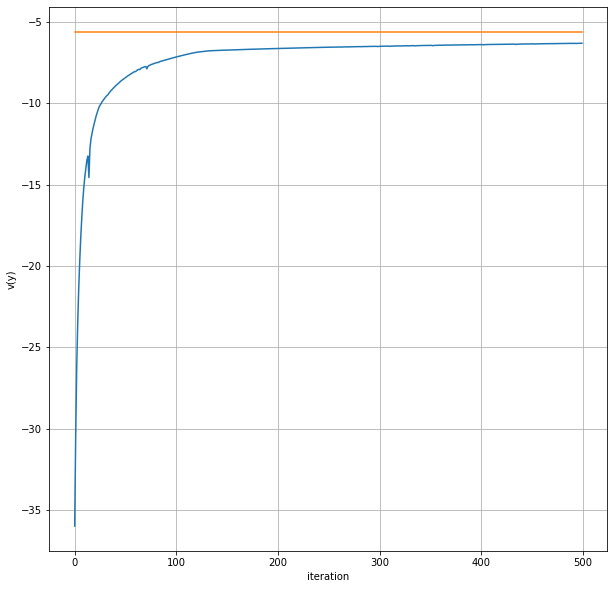

In [6]:
if k > 1:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(results1, results2)
    ax.plot(results1, modelQ.Objval*np.ones(k))
    ax.set(xlabel='iteration', ylabel='v(y)')
    ax.grid()
    plt.show()